# Library Imports

In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F

import json
import random
from collections import defaultdict
import time
import sys
import io
import pandas as pd
import matplotlib.pyplot as plt


from transformers import AutoTokenizer 
from tokenizers.pre_tokenizers import Whitespace
import warnings
import pickle

# Setting GPU/CPU device

In [2]:
# Check if CUDA is available and print more information
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device count: {torch.cuda.device_count()}")
    print(f"Current CUDA device: {torch.cuda.current_device()}")
    device = torch.device("cuda")
else:
    print("CUDA is not available. Using CPU instead.")
    device = torch.device("cpu")

CUDA available: True
CUDA device count: 8
Current CUDA device: 0


# Using BPE tokenizer from previous assignment

In [3]:
class BPETokenizer:
    def __init__(self, vocab_size=4000):
        self.vocab_size = vocab_size
        self.vocab = ["<|endoftext|>"]
        self.word_freqs = defaultdict(int)
        self.merges = {}
        self.tokenizer = AutoTokenizer.from_pretrained("gpt2")

    def compute_pair_freqs(self,splits):
        pair_freqs = defaultdict(int)
        for word, freq in self.word_freqs.items():
            split = splits[word]
            if len(split) == 1:
                continue
            for i in range(len(split) - 1):
                pair = (split[i], split[i + 1])
                pair_freqs[pair] += freq
        return pair_freqs
    
    def merge_pair(self,a, b, splits):
        for word in self.word_freqs:
            split = splits[word]
            if len(split) == 1:
                continue

            i = 0
            while i < len(split) - 1:
                if split[i] == a and split[i + 1] == b:
                    split = split[:i] + [a + b] + split[i + 2 :]
                else:
                    i += 1
            splits[word] = split
        return splits

    def build_vocab(self, corpus):
        for text in corpus:
            self.tokenizer.backend_tokenizer.pre_tokenizer = Whitespace()
            text= ' Ġ'.join(text.split())
            words_with_offsets = self.tokenizer.backend_tokenizer.pre_tokenizer.pre_tokenize_str(text)
            new_words = [word for word, offset in words_with_offsets]
            for word in new_words:
                self.word_freqs[word] += 1

        alphabet = []

        for word in self.word_freqs.keys():
            for letter in word:
                if letter not in alphabet:
                    alphabet.append(letter)
        alphabet.sort()


        # Add every unique character to the vocab
        for char in alphabet:
            if char not in self.vocab:
                self.vocab.append(char)

        splits = {word: [c for c in word] for word in self.word_freqs.keys()}

        while len(self.vocab) < self.vocab_size:
            pair_freqs = self.compute_pair_freqs(splits)
            best_pair = ""
            max_freq = None
            for pair, freq in pair_freqs.items():
                if max_freq is None or max_freq < freq:
                    best_pair = pair
                    max_freq = freq
            if len(best_pair) == 2:
                splits = self.merge_pair(best_pair[0],best_pair[1], splits)
                self.merges[best_pair] = best_pair[0] + best_pair[1]
                self.vocab.append(best_pair[0] + best_pair[1])
            else:
                break


    def tokenize(self,text):
        self.tokenizer.backend_tokenizer.pre_tokenizer = Whitespace()
        pre_tokenize_result = self.tokenizer._tokenizer.pre_tokenizer.pre_tokenize_str(text)
        pre_tokenized_text = [word for word, offset in pre_tokenize_result]
        splits = [[l for l in word] for word in pre_tokenized_text]


        for word in pre_tokenized_text:
            for char in word:
                if char not in self.vocab:
                    self.vocab.append(char)  

        for pair, merge in self.merges.items():
            for idx, split in enumerate(splits):
                i = 0
                while i < len(split) - 1:
                    if split[i] == pair[0] and split[i + 1] == pair[1]:
                        split = split[:i] + [merge] + split[i + 2 :]
                    else:
                        i += 1
                splits[idx] = split

        return sum(splits, [])

    def save(self, file_path):
        """
        Save the tokenizer's state to a file.
        """
        state = {
            'vocab_size': self.vocab_size,
            'vocab': self.vocab,
            'word_freqs': dict(self.word_freqs),
            'merges': self.merges
        }
        with open(file_path, 'wb') as f:
            pickle.dump(state, f)

    @classmethod
    def load(cls, file_path):
        """
        Load a tokenizer's state from a file.
        """
        with open(file_path, 'rb') as f:
            state = pickle.load(f)
        
        tokenizer = cls(vocab_size=state['vocab_size'])
        tokenizer.vocab = state['vocab']
        tokenizer.word_freqs = defaultdict(int, state['word_freqs'])
        tokenizer.merges = state['merges']
        return tokenizer


# Encode Decode function implemenation

In [4]:
tokenizer_file = "tokenizer.pkl"

def encode(text):
    # Step 1: Encode, decode, and normalize the text
    text = text.encode('utf-8').decode('utf-8').lower()
    text = 'Ġ'.join(text.split())

    # Step 2: Load tokenizer
    tokenizer_instance = BPETokenizer.load(tokenizer_file)

    # Step 3: Create a dictionary for vocabulary for O(1) lookups
    vocab_dict = {token: idx for idx, token in enumerate(tokenizer_instance.vocab)}

    # Step 4: Tokenize the text
    tokens = tokenizer_instance.tokenize(text)

    # Step 5: Generate token IDs efficiently
    unknown_token_id = len(tokenizer_instance.vocab) 
    token_ids = [vocab_dict.get(t, unknown_token_id) for t in tokens]

    return token_ids

def decode(token_ids):
    tokenizer_instance = BPETokenizer.load(tokenizer_file)
    tokens = []
    for id in token_ids:
        if 0 <= id < len(tokenizer_instance.vocab):
            tokens.append(tokenizer_instance.vocab[id])
        else:
            # Handle out-of-vocabulary token IDs
            tokens.append('<UNK>')
    decoded_string = ''.join(tokens)
    decoded_string = decoded_string.replace('Ġ', ' ').strip()
    return decoded_string

# Data Handling

In [5]:
# Helper function to load JSON data
def load_json_data(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    return data

In [6]:
def find_space_low_strings(strings, low_bound, up_bound):
    result = []
    for index, text in enumerate(strings):
        total_chars = len(text)
        space_count = text.count(' ')

        # Calculate percentage if there are non-space characters
        if total_chars > space_count:
            percentage = (space_count / (total_chars - space_count)) * 100
            if percentage > low_bound and percentage < up_bound:
                result.append(text)

    return result

In [7]:
# Load English and Amharic data
english_data = load_json_data('alpaca_data_cleaned_cleaned_corpus.json')
amharic_data = load_json_data('Amharic_cleaned_corpus.json')

# Using data samples having longer context
long_english_data = [s for s in english_data if len(s) >= 500]
long_amharic_data = [s for s in amharic_data if len(s) >= 500]
print(len(long_english_data))
print(len(long_amharic_data))

long_english_data = find_space_low_strings(long_english_data, 17, 22)
long_amharic_data = find_space_low_strings(long_amharic_data, 22, 26)


# Control how many elements to take from each file
num_english_elements = 1000  # Number of elements from English file
num_amharic_elements = 1000  # Number of elements from Amharic file


random.shuffle(long_english_data)
random.shuffle(long_amharic_data)
# Slice data from both files as per the desired number of elements
english_list = long_english_data[:num_english_elements]
amharic_list = long_amharic_data[:num_amharic_elements]

24653
16555


In [8]:
# Combine the texts
combined_list = english_list  + amharic_list

# Shuffle the combined text
def shuffle_text(text_list, seed=42):
    random.seed(seed)
    # Split into blocks of text
    random.shuffle(text_list)  # Shuffle the text blocks
    return ' '.join(text_list)

# Shuffle the combined text
text = shuffle_text(combined_list)
print(len(text))

2146699


In [9]:
%%time
# Encode the entire dataset
# data = torch.tensor(encode(text), dtype=torch.long)
data = torch.load('tensor_data.pt')

# Split into train and validation sets
n = int(0.8 * len(data))
train_data = data[:n]
val_data = data[n:]


def get_batch(split):
    data = train_data if split == 'train' else val_data
    # Making sure we don't try to start at an index that would give us an incomplete sequence
    max_index = len(data) - hyperparams['block_size'] - 1
    if max_index < 1:
        raise ValueError(f"Not enough data for sequence length {hyperparams['block_size']}")
    
    ix = torch.randint(max_index, (hyperparams['block_size'],))
    
    x = torch.stack([data[i:i+hyperparams['block_size']] for i in ix])
    y = torch.stack([data[i+1:i+hyperparams['block_size']+1] for i in ix])
    
    return x.to(device), y.to(device)

CPU times: user 2.69 ms, sys: 66.9 ms, total: 69.6 ms
Wall time: 68.3 ms


<timed exec>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


In [10]:
# Evaluation function
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(hyperparams['eval_iters'])
        for k in range(hyperparams['eval_iters']):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

# Hyperparameters Setup

In [11]:
"""
These are our hyperparameters. Feel free to change
"""
# Hyperparameters
hyperparams = {}
hyperparams['batch_size'] = 128 # This defines the number of samples processed in one forward/backward pass of the model.
hyperparams['block_size'] = 256  # sequence length || This represents the length of the input sequences the model will process.
hyperparams['max_iters'] = 3000 # This sets the maximum number of training iterations (or steps) the model will perform.
                 # The training will stop after this many iterations, even if other stopping criteria haven't been met.
hyperparams['eval_interval'] = 300 # This determines how often the model's performance is evaluated during training.
hyperparams['learning_rate'] = 1e-2 # This controls the step size at each iteration while moving toward a minimum of the loss function.
hyperparams['eval_iters'] = 200
hyperparams['n_embd'] = 512 #  Refers to the dimensionality of the embedding space.
hyperparams['n_hidden'] = 1024
hyperparams['dropout'] = 0.3 # Dropout is a regularization technique to prevent overfitting.

In [12]:
"""
Please change this with the tokenizer you have created for your dataset.
"""
# Create the vocabulary
chars = sorted(list(set(text)))
vocab_size = 4000 # check BPETokenizer initialization

print(chars)
print(vocab_size)

[' ', '#', '$', '%', '&', '*', '+', '>', '@', '[', '\\', ']', '^', '_', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '{', '|', '}', '~', '°', '²', '³', '¹', '×', 'é', 'ö', '÷', 'λ', 'ሀ', 'ሁ', 'ሂ', 'ሃ', 'ሄ', 'ህ', 'ሆ', 'ለ', 'ሉ', 'ሊ', 'ላ', 'ሌ', 'ል', 'ሎ', 'ሏ', 'ሐ', 'ሑ', 'ሒ', 'ሔ', 'ሕ', 'መ', 'ሙ', 'ሚ', 'ማ', 'ሜ', 'ም', 'ሞ', 'ሟ', 'ሠ', 'ሣ', 'ሥ', 'ሦ', 'ረ', 'ሩ', 'ሪ', 'ራ', 'ሬ', 'ር', 'ሮ', 'ሯ', 'ሰ', 'ሱ', 'ሲ', 'ሳ', 'ሴ', 'ስ', 'ሶ', 'ሷ', 'ሸ', 'ሹ', 'ሺ', 'ሻ', 'ሼ', 'ሽ', 'ሾ', 'ሿ', 'ቀ', 'ቁ', 'ቂ', 'ቃ', 'ቄ', 'ቅ', 'ቆ', 'ቋ', 'በ', 'ቡ', 'ቢ', 'ባ', 'ቤ', 'ብ', 'ቦ', 'ቧ', 'ቨ', 'ቪ', 'ቫ', 'ቬ', 'ቭ', 'ቮ', 'ተ', 'ቱ', 'ቲ', 'ታ', 'ቴ', 'ት', 'ቶ', 'ቷ', 'ቸ', 'ቹ', 'ቺ', 'ቻ', 'ቼ', 'ች', 'ቾ', 'ቿ', 'ኃ', 'ኄ', 'ኅ', 'ኋ', 'ነ', 'ኑ', 'ኒ', 'ና', 'ኔ', 'ን', 'ኖ', 'ኗ', 'ኘ', 'ኙ', 'ኚ', 'ኛ', 'ኜ', 'ኝ', 'ኞ', 'ኟ', 'አ', 'ኡ', 'ኢ', 'ኤ', 'እ', 'ኦ', 'ኧ', 'ከ', 'ኩ', 'ኪ', 'ካ', 'ኬ', 'ክ', 'ኮ', 'ኳ', 'ኸ', 'ወ', 'ዉ', 'ዊ', 'ዋ', 'ዌ', 'ው', 'ዎ', 'ዐ', 'ዑ', 'ዒ', 'ዓ', 'ዔ', 'ዕ', 'ዖ', 'ዘ', 'ዙ'

# Model Class Definition

In [13]:
class SimpleRNNModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hyperparams['n_embd'])
        # print(f"Embedding layer: {vocab_size} x {n_embd}")
        # self.rnn = nn.RNN(n_embd, n_hidden, batch_first=True)
        self.rnn = nn.LSTM(hyperparams['n_embd'], hyperparams['n_hidden'], batch_first=True)
        # print(f"RNN layer: {n_embd} -> {n_hidden}")
        self.fc = nn.Linear(hyperparams['n_hidden'], vocab_size)
        # print(f"Linear layer: {n_hidden} -> {vocab_size}")
        self.dropout = nn.Dropout(hyperparams['dropout'])


    def forward(self, idx, targets=None):
        B, T = idx.shape
        # print(f"Input shape in forward: {idx.shape}")
        # print(f"Max token in input: {idx.max()}")
        
        embeds = self.embedding(idx)
        # print(f"Embedding output shape: {embeds.shape}")
        
        output, _ = self.rnn(embeds)
        # print(f"RNN output shape: {output.shape}")
        
        output = self.dropout(output)
        logits = self.fc(output)
        # print(f"Logits shape: {logits.shape}")
        
        if targets is None:
            loss = None
        else:
            # print(f"Targets shape: {targets.shape}")
            # print(f"Max token in targets: {targets.max()}")
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)
        
        return logits, loss


    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -hyperparams['block_size']:]
            embeds = self.embedding(idx_cond)
            output, _ = self.rnn(embeds)
            logits = self.fc(output[:, -1, :])
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx


In [28]:
""" Lets get things ready for the training """
model = SimpleRNNModel().to(device) # Send the model to GPU
print(sum(p.numel() for p in model.parameters())/1e6, 'M parameters') # How many parameters we have in our model?

# Create an optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=hyperparams['learning_rate'])

12.447648 M parameters


In [15]:
print(f"Train data size: {len(train_data)}")
print(f"Validation data size: {len(val_data)}")
print(f"Vocabulary size: {vocab_size}")

Train data size: 10100769
Validation data size: 2525193
Vocabulary size: 4000


In [16]:
def calculate_perplexity(model, data, block_size=hyperparams['block_size'], batch_size=hyperparams['batch_size']):
    model.eval()
    total_loss = 0
    total_tokens = 0

    with torch.no_grad():
        for i in range(0, len(data) - block_size, block_size):
            current_batch_size = batch_size
            
            # Adjust batch size for the last batch if not enough data
            if i + block_size * batch_size > len(data):
                current_batch_size = (len(data) - i) // block_size
            
            x = []
            y = []
            
            # Collect chunks for x and y, ensuring they're consistent
            for j in range(0, block_size * current_batch_size, block_size):
                x_chunk = data[i+j : i+j+block_size]
                y_chunk = data[i+j+1 : i+j+block_size+1]
                
                # Skip this batch if we have any incomplete chunks
                if len(x_chunk) == block_size and len(y_chunk) == block_size:
                    x.append(x_chunk)
                    y.append(y_chunk)

            if len(x) == 0 or len(y) == 0:
                continue

            x = torch.stack(x).to(model.embedding.weight.device)
            y = torch.stack(y).to(model.embedding.weight.device)

            logits, _ = model(x)
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), y.view(-1), reduction='sum')
            
            total_loss += loss.item()
            total_tokens += y.numel()

    avg_loss = total_loss / total_tokens
    perplexity = torch.exp(torch.tensor(avg_loss))

    return perplexity.item()


# Training

In [17]:
save_path = 'cp_10k_500char_words_v5/'

In [ ]:
# Initialize variables to track the best model
best_val_loss = float('inf')
best_model_state = None
train_losses = []
val_losses = []
perplexities = []
save_path = '../'
for iter in range(hyperparams['max_iters']):
    try:
        # Evaluation phase
        if iter % hyperparams['eval_interval'] == 0:
            model.eval()  # Set to evaluation mode for validation
            losses = estimate_loss()
            train_loss = losses['train']
            val_loss = losses['val']
            train_losses.append(train_loss)
            val_losses.append(val_loss)

            # Calculate perplexity
            perplexity = calculate_perplexity(model, val_data, hyperparams['block_size'], hyperparams['batch_size'])
            perplexities.append(perplexity)

            print(f"Step {iter}: train loss {train_loss:.4f}, val loss {val_loss:.4f}, perplexity {perplexity:.4f}")

            # Save the model and check for overfitting
            torch.save(model.state_dict(), f"{save_path}checkpoint_{iter}.pt")
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model_state = model.state_dict()
                torch.save(best_model_state, f"{save_path}best_model.pt")
                print("New best model saved.")
            
            if len(val_losses) > 3 and val_losses[-1] > val_losses[-2] > val_losses[-3]:
                print("Overfitting detected. Exiting training.")
                break

        # Training phase
        model.train()  # Set to training mode
        print(f"\nIteration {iter}:")
        xb, yb = get_batch('train')
        
        logits, loss = model(xb, yb)
        print(f"Loss: {loss.item()}")
        
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()
        
    except RuntimeError as e:
        print(f"Error at iteration {iter}: {e}")
        print("Last shapes:")
        print(f"xb shape: {xb.shape}, yb shape: {yb.shape}")
        print(f"xb max token: {xb.max()}, yb max token: {yb.max()}")
        break

In [ ]:
# Save final training state
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    torch.save(model.state_dict(), f"{save_path}best_model_final.pt")
    print("Best model saved as best_model_final.pt")

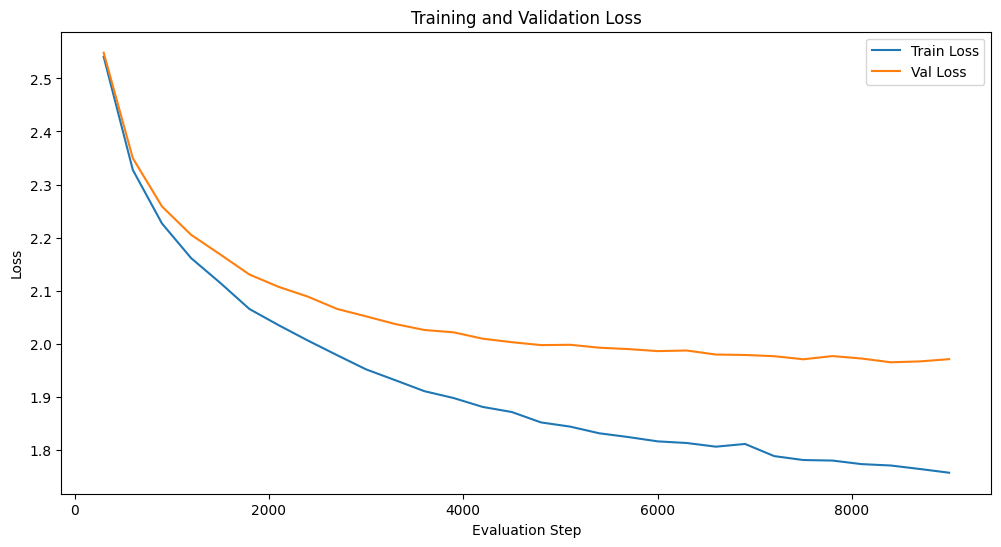

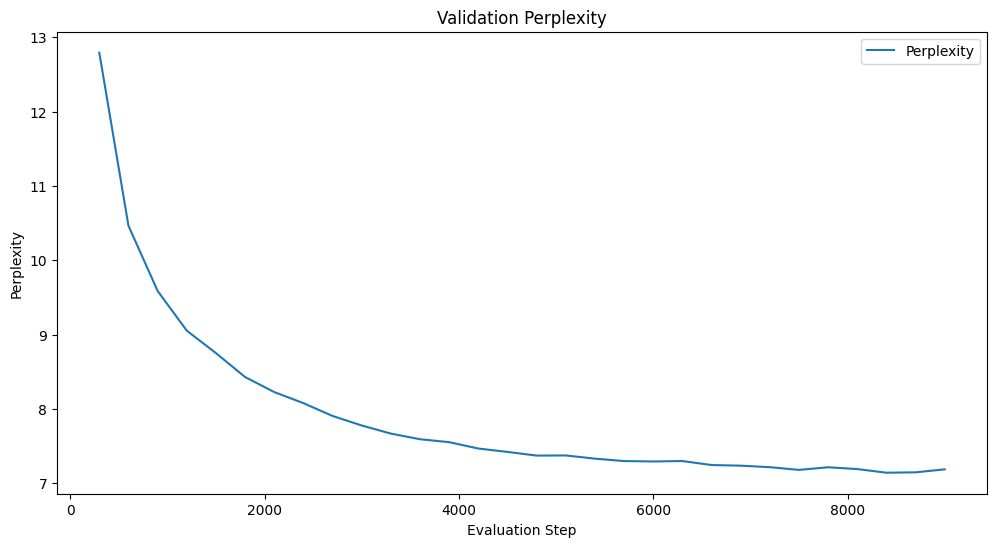

In [19]:
# Plot training and validation losses
plt.figure(figsize=(12, 6))
plt.plot(list(range(300, 300*len(perplexities),300)), train_losses[1:], label="Train Loss")
plt.plot(list(range(300, 300*len(perplexities),300)), val_losses[1:], label="Val Loss")
plt.xlabel("Evaluation Step")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

# Plot perplexity curve
plt.figure(figsize=(12, 6))
plt.plot(list(range(300, 300*len(perplexities),300)), perplexities[1:], label="Perplexity")
plt.xlabel("Evaluation Step")
plt.ylabel("Perplexity")
plt.title("Validation Perplexity")
plt.legend()
plt.show()

In [ ]:
# Generate step values, incremented by 300
steps_ = list(range(0, 300 * len(train_losses), 300))
train_losses = [round(float(t.item()), 3) for t in train_losses]
val_losses = [round(float(t.item()), 3) for t in val_losses]

# Create a DataFrame
df = pd.DataFrame({
    'step': steps_,
    'training_loss': train_losses,
    'val_loss': val_losses
})

# Save to CSV
df.to_csv(f'{save_path}loss_values.csv', index=False)


# Create a DataFrame
perplexity_df = pd.DataFrame({
    'step': steps_,
    'perplexity': [round(float(t), 3) for t in perplexities]
})

# Save to CSV
perplexity_df.to_csv(f'{save_path}perplexity.csv', index=False)


In [29]:
# Generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(model.generate(context, max_new_tokens=500)[0].tolist()))

<|endoftext|>ብ<UNK><UNK><UNK><UNK>ir ተ<UNK>ers<UNK><UNK><UNK><UNK>ዥ<UNK>ዊ<UNK><UNK><UNK><UNK> ऊर्जाጢ<UNK>कर<UNK><UNK><UNK>ፀ<UNK> to adቄ<UNK><UNK><UNK>त्र<UNK><UNK><UNK><UNK><UNK><UNK>ाव<UNK><UNK><UNK> ई<UNK><UNK><UNK><UNK>ቶकृ<UNK><UNK><UNK><UNK>ጠ<UNK><UNK><UNK><UNK><UNK><UNK>मे<UNK>ग्रस–ኗ<UNK><UNK><UNK><UNK><UNK><UNK><UNK>ङ्<UNK><UNK><UNK><UNK><UNK><UNK><UNK><UNK><UNK><UNK><UNK><UNK>ኅ<UNK><UNK><UNK><UNK><UNK>ं<UNK>ዌ<UNK><UNK>ऊ<UNK><UNK><UNK>ive<UNK> re<UNK><UNK><UNK><UNK>ख्या दि य<UNK><UNK><UNK><UNK><UNK> कम<UNK><UNK><UNK><UNK><UNK><UNK><UNK><UNK><UNK><UNK>el<UNK><UNK><UNK><UNK>ntन्त<UNK><UNK><UNK><UNK><UNK><UNK> प्रभाव<UNK><UNK><UNK><UNK>ኗ<UNK>नं मह<UNK><UNK><UNK>का helpलऽ<UNK><UNK><UNK><UNK><UNK>enत<UNK><UNK><UNK><UNK><UNK>u<UNK><UNK><UNK>ou<UNK><UNK><UNK>ኢ<UNK> परमाणुial<UNK><UNK><UNK><UNK>ሩ<UNK> त<UNK> गर्नुहोस्<UNK>ሺ<UNK><UNK> प्रदूषण<UNK><UNK><UNK><UNK><UNK><UNK><UNK><UNK> compleदा<UNK><UNK><UNK> जेकरा<UNK><UNK>चार<UNK> बहु<UNK><UNK>g<UNK><UNK><UNK><UNK><UNK>ፊ<UNK><UNK>ar<UNK><UN

In [31]:
context = torch.tensor(encode("Once upon a time"), dtype=torch.long, device=device).unsqueeze(0)
print(decode(model.generate(context, max_new_tokens=100)[0].tolist()))

once upon a time<UNK>ሩ<UNK><UNK><UNK><UNK>इ<UNK>प्त<UNK><UNK><UNK><UNK><UNK><UNK><UNK><UNK><UNK> केरऽ मिैत<UNK><UNK> न्यू<UNK><UNK><UNK> घ<UNK>द्ध<UNK>ld<UNK><UNK>ूर्ण<UNK><UNK><UNK><UNK><UNK> in<UNK><UNK> बी fने<UNK>]<UNK><UNK><UNK>ከ<UNK>ide<UNK>एकोage<UNK><UNK>ሃ<UNK><UNK>थ<UNK><UNK>सी<UNK><UNK>र्<UNK><UNK><UNK><UNK><UNK>ስተ<UNK>हरूको<UNK>ቼ<UNK><UNK><UNK><UNK><UNK><UNK><UNK>ሪያनि<UNK> कऱil गर्द<UNK>म् ओ<UNK><UNK><UNK><UNK>


In [36]:
context = torch.tensor(encode("የተመጣጠነ እና የተመጣጠነ ምግብ ይመገቡ፡ ምግብዎ የተለያዩ አትክልትና ፍራፍሬ፣ ዘንበል"), dtype=torch.long, device=device).unsqueeze(0)
print(decode(model.generate(context, max_new_tokens=100)[0].tolist()))

የተመጣጠነ እና የተመጣጠነ ምግብ ይመገቡ፡ ምግብዎ የተለያዩ አትክልትና ፍራፍሬ፣ ዘንበል ያደርገዋል፣ አዳዲስ እድሎችን አልፈለች እና እራስዎን በተናጋሪ ጊዜ ማሸነፍ እችላለሁ። ቦ ኤን ኤን ኤን እንደ ጥቁር እንቅስቃሴዎች ቀደም ካልሆኑ አስከፊ መስኮችን ያሰሳሰሉ እና ከትይዩ ስፋት የሚቆጣጠርበት


# Loading the save model

In [33]:
model_path = f'{save_path}best_model.pt'

In [34]:
model = SimpleRNNModel()
model.load_state_dict(torch.load(model_path))
model.to(device)

/tmp/ipykernel_968398/955188772.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


SimpleRNNModel(
  (embedding): Embedding(4000, 512)
  (rnn): LSTM(512, 1024, batch_first=True)
  (fc): Linear(in_features=1024, out_features=4000, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

In [35]:
context = torch.tensor(encode("Once upon a time"), dtype=torch.long, device=device).unsqueeze(0)
print(decode(model.generate(context, max_new_tokens=100)[0].tolist()))

once upon a time elaborate on adventure related to an image used in its blood and on another started to create a train during different parts of the needs to provide example the relationship can be a lot of compress focused on the other and job re
